# GNN_goal_recognizer


##Installations

In [4]:
'''
!pip install torch_geometric
!pip install wandb -qU
!pip install networkx==3.4.2
pip install torchinfo
'''

'\n!pip install torch_geometric\n!pip install wandb -qU\n!pip install networkx==3.4.2\npip install torchinfo\n'

##Utils

In [5]:
# Helper Functions for Visualization

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.data import Data


def visualize_graph(
    title,
    G,
    color,
    labels=None,
    train_mask=None,
    pred_mask=None,
    node_feature=False,
    edge_attr=None,
    node_size=100,
    img_size=(8, 8)
):
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np

    # Aggiungi pesi agli archi se presenti
    if edge_attr is not None:
        for i, (u, v) in enumerate(G.edges()):
            G[u][v]['weight'] = edge_attr[i].item() if hasattr(edge_attr[i], 'item') else edge_attr[i]

    plt.figure(figsize=img_size)
    plt.title(title)

    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(
        G, pos, with_labels=node_feature,
        node_size=node_size, node_color=color, cmap="Set2"
    )

    # Evidenzia goal reali (train_mask)
    if train_mask is not None:
        nx.draw_networkx_nodes(
            G, pos=pos,
            nodelist=[i for i, t in enumerate(train_mask) if t],
            node_color=[c for c, t in zip(color, train_mask) if t],
            cmap="Set2", edgecolors='red', linewidths=2, node_size=node_size
        )

    # Evidenzia goal predetto (pred_mask)
    if pred_mask is not None:
        nx.draw_networkx_nodes(
            G, pos=pos,
            nodelist=[i for i, t in enumerate(pred_mask) if t],
            node_color=[c for c, t in zip(color, pred_mask) if t],
            cmap="Set2", edgecolors='lime', linewidths=3, node_size=node_size
        )

    # Disegna etichette degli archi (se ci sono pesi)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    if len(edge_labels) > 0:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legenda
    legend_handles = []
    legend_labels = []

    if train_mask is not None and any(train_mask):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markeredgecolor='red', markersize=10, label='Goal reale'))
        legend_labels.append('Goal reale')
    if pred_mask is not None and any(pred_mask):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                         markeredgecolor='lime', markersize=10, label='Goal predetto'))
        legend_labels.append('Goal predetto')

    if legend_handles:
        plt.legend(handles=legend_handles, loc='upper right')

    plt.show()


def visualize_embedding(title, h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.legend(handles=scatter.legend_elements()[0], labels=labels.values())
    plt.show()

In [6]:
import torch
from torch_geometric.data import Data
import torch.optim as optim

##Classes

###Map

In [7]:
#map class

from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Map:
    V: List[List[Tuple[int, int, int]]]
    E: List[Tuple[int, int]]
    Y: List[List[int]]
    O: List[List[int]]
    Optimality: List[float]
    AvgLength: float
    ObstaclePerc: float

In [8]:
from torch_geometric.data import InMemoryDataset

class MyDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super().__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

    @property
    def num_features(self):
        return self[0].num_node_features

    @property
    def num_classes(self):
        y_all = torch.cat([d.y for d in self])
        return int(y_all.max().item() + 1)


###


###MapLoader

In [9]:
#from google.colab import drive
import json

#drive.mount('/content/drive')

def load_maps_from_drive_unified(type,size):
    """
    Carica tutte le istanze di Map insieme dal file unified
    Restituisce una lista di oggetti Map.
    """
    if size not in [8, 16, 32, 128]:
        print("size deve essere 16, 32 o 128")
        return []

    all_maps = []
    #file_path = f"/content/drive/MyDrive/Progetto_deep_learning/Dataset/{type}{size}.json"
    file_path = f"{type}{size}.json"
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"File {i} non trovato o non leggibile")
        return None

    if not data:
        print(f"File {i} vuoto")
        return None



    all_maps.extend([Map(**map_dict) for map_dict in data])

    return all_maps


##Creation and loading of the dataset

In [10]:
from torch_geometric.data import Dataset, Data
import torch

class GoalRecognitionDataset(Dataset):
    def __init__(self, maps, transform=None):
        """
        maps: lista di mappe (con la griglia + edge_index già costruito)
        paths: lista di percorsi (ogni percorso è lista di nodi [src, ..., goal])
        """
        super().__init__(None, transform)
        self.maps = maps

    '''
    @percentage è la percentuale di percorso che passo al metodo, cioè quanto è lungo il percorso delle varie entries
    prima generavamo tutti i percorsi aumentati di uno alla volta, ora posso scegliere quanto farlo lungo
    '''
    def generate_entries(self,map_index, path_index,print_or_not, percentage=100):
        """
        Genera le entry per ogni sottopercorso (minimo 2 elementi) di un path di O.
        Ogni entry è (V_mod, E, Y).
        """
        entries = []

        len_entr = len(self.maps[map_index].O[path_index])
        new_len = int((100-percentage)*len_entr/100)
        if new_len < 2:
          new_len = 2
        #for step in range(2, len(self.maps[map_index].O[path_index])+1):
        for step in range(new_len, len_entr+1):
            V_mod = [row.copy() for row in self.maps[map_index].V[path_index]]

            visited = self.maps[map_index].O[path_index][:step-1]         # nodi già visitati
            agent_pos = self.maps[map_index].O[path_index][step-1]        # posizione attuale
            future = self.maps[map_index].O[path_index][step:]            # nodi futuri -> liberi

            if(print_or_not):
              print(visited)

            for v in visited:
                V_mod[v] = [0,0,1]

            V_mod[agent_pos] = [0,1,0]

            for f in future:
                V_mod[f] = [1,0,0]

            x = torch.tensor(V_mod, dtype=torch.float)
            edge_index = torch.tensor(self.maps[map_index].E, dtype=torch.long).t().contiguous()


            y = torch.tensor(self.maps[map_index].Y[path_index], dtype=torch.float)

            # Esponenziazione per aumentare il contrasto
            alpha = 1.0
            y_transformed = y ** alpha

            # Normalizza di nuovo
            y_transformed = y_transformed / y_transformed.sum()

            # Ora puoi usarlo come target
            entries.append(Data(x=x, edge_index=edge_index, y=y_transformed))

        return entries

    def generate_all_entries(self):
        """
        Genera tutte le entry per tutti i percorsi di tutte le mappe.
        """
        entries = []

        for map in range(len(self.maps)):
            for path in range(len(self.maps[map].O)):
                for entry in self.generate_entries(map, path,False, 100): #30 da modificare se voglio sottopercorsi più o meno lunghi
                    entries.append(entry)

        return entries

CARICA TUTTE LE MAPPE

In [11]:

import torch
from torch_geometric.data import Data

size=8
maps=load_maps_from_drive_unified("DfsRandomJump",size)


In [12]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

goalRecognitionDataset = GoalRecognitionDataset(maps)
dataset = goalRecognitionDataset.generate_all_entries()

# Suddivisione in train / val / test (80% / 10% / 10%)
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len   = int(0.1 * total_len)
test_len  = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


##Logging WanDB


In [13]:
# Log in to your W&B account
import wandb
import random
import math

In [14]:
wandb.login(key="38de765b09e71e9b6b33218b7ade62f2349d81c0")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/deeplearning/.netrc
wandb: Currently logged in as: m-lizza002 (m-lizza002-university-of-brescia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

##Sweeps

###Define a sweep

In [26]:
parameters_dict = {
    # --- Ottimizzazione ---
    'optimizer': {
        'values': ['Adam']  # Solo Adam, SGD non va bene qui
    },
    'learning_rate': {
        # Cerca valori tra 0.0001 e 0.005 (logaritmico)
        'distribution': 'log_uniform_values',
        'min': 0.001,
        'max': 0.01
    },
    'batch_size': {
        'values': [32, 64] # 32 è un buon compromesso
    },
    'epochs': {
        'value': 50 # Aumentiamo un po' per dare tempo di convergere
    },

    # --- Architettura ---
    'num_layers': {
        # Testiamo reti poco profonde (2) vs profonde (4, 6)
        'values': [4, 6]
    },
    'hidden_channels': {
        # Unica dimensione per tutti i layer interni per semplicità
        'values': [64, 128]
    },
    'dropout': {
        'values': [0.0, 0.2]
    }
}

In [27]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': parameters_dict
    }

In [28]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'batch_size': {'values': [32, 64]},
                'dropout': {'values': [0.0, 0.2]},
                'epochs': {'value': 50},
                'hidden_channels': {'values': [64, 128]},
                'learning_rate': {'distribution': 'log_uniform_values',
                                  'max': 0.01,
                                  'min': 0.001},
                'num_layers': {'values': [4, 6]},
                'optimizer': {'values': ['Adam']}}}


###Initialize the Sweep

In [ ]:
#sweep_id = wandb.sweep(sweep_config, project="Node_Classificator")

Create sweep with ID: iyuvwzrf
Sweep URL: https://wandb.ai/m-lizza002-university-of-brescia/Node_Classificator/sweeps/iyuvwzrf


##Training


### Node Classificator

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import softmax as pyg_softmax
from torch_scatter import scatter_sum, scatter_max

SAVE_DIR = "./gnn/"
MODEL_NAME = "node_cls_soft.pth"

# Dizionario per salvare i migliori parametri globalmente
best_params = {}

class NodeClassificator(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout=0.0):
        super(NodeClassificator, self).__init__()
        
        self.dropout_p = dropout
        self.convs = nn.ModuleList()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        # --- Creazione Dinamica dei Layer ---
        # 1. Primo Layer: Input -> Hidden
        self.convs.append(GCNConv(in_channels, hidden_channels))

        # 2. Layer Intermedi: Hidden -> Hidden
        # Se num_layers=2, questo loop non gira (corretto)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # 3. Ultimo Layer GCN: Hidden -> Hidden (prima del lineare finale)
        # Nota: in alcune architetture l'ultimo GCN va direttamente a output, 
        # qui manteniamo la struttura GCN -> Linear
        self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # 4. Layer Lineare finale: Hidden -> 1 (Score)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch_index):
        # Passaggio attraverso tutti i layer GCN
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.relu(x)
            x = self.dropout(x)
        
        # Proiezione finale a scalare
        logits = self.lin(x).squeeze(-1)
        
        # Normalizzazione per Grafo (Softmax per grafi disgiunti)
        probs = pyg_softmax(logits, batch_index)
        
        return probs

    # ------------------------------- TRAINING --------------------------------

    def train_gcn(self, train_loader, val_loader, optimizer, device, num_epochs, patience=10):
        
        # --- 1. SCHEDULER: FRENO AUTOMATICO ---
        # Se la val_loss non scende per 'patience' epoche (es. 5),
        # moltiplica il Learning Rate per 'factor' (es. 0.5, quindi lo dimezza).
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.2, 
            patience=5, 
            min_lr=1e-6, 
            verbose=True # Scriverà nel log quando riduce il LR
        )

        best_val_loss = float('inf')
        best_val_acc = 0.0
        epochs_no_improve = 0

        for epoch in range(num_epochs):
            self.train()
            total_loss = 0
            total_peak_match = 0
            total_graphs = 0

            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Forward
                probs = self(batch.x, batch.edge_index, batch.batch)
                
                # --- CALCOLO LOSS MANUALE (Cross Entropy su Soft Targets) ---
                log_probs = torch.log(probs + 1e-15) # Stabilità numerica
                target_probs = batch.y.float()
                
                # Loss = - sum(target * log(pred))
                loss_per_node = -target_probs * log_probs
                # Somma per grafo e media sul batch
                loss = scatter_sum(loss_per_node, batch.batch).mean()

                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Metrica Peak Accuracy
                _, pred_argmax = scatter_max(probs, batch.batch)
                _, target_argmax = scatter_max(target_probs, batch.batch)
                total_peak_match += (pred_argmax == target_argmax).sum().item()
                total_graphs += batch.num_graphs

            avg_train_loss = total_loss / len(train_loader)
            train_peak_acc = total_peak_match / total_graphs

            # Validazione
            val_loss, val_top1_acc, val_topK_acc = self.eval_gcn(val_loader, device, 10)

            # --- 2. STEP SCHEDULER ---
            # Informiamo il scheduler di come sta andando la validation loss
            scheduler.step(val_loss)
            
            # Recuperiamo il LR attuale per stamparlo
            current_lr = optimizer.param_groups[0]['lr']

            print(f"Epoch {epoch:03d} | LR: {current_lr:.6f} | "
                  f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Top1 Acc: {val_top1_acc:.4f} | "
                  f"TopK Acc: {val_topK_acc:.4f}")
            
            # Se usi WandB, puoi loggare il LR qui:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "val_loss": val_loss,
                "val_acc": val_top1_acc,
                "val_topk_acc": val_topK_acc,
                "lr": current_lr
            })

            # Early Stopping e Salvataggio
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                
                # Aggiorna best_params globali
                best_params.update({
                    'optimizer': optimizer.__class__.__name__,
                    'dropout': self.dropout_p,
                    'epochs': epoch,
                    'learning_rate': optimizer.param_groups[0]['lr'],
                    'batch_size': getattr(train_loader.dataset, 'batch_size', None) if hasattr(train_loader, 'dataset') else train_loader.batch_size,
                    'num_layers': len(self.convs), # Salva il numero di layer
                    'hidden_channels': self.convs[0].out_channels,
                    'in_channels': self.convs[0].in_channels
                })

                if not os.path.exists(SAVE_DIR):
                    os.mkdir(SAVE_DIR)
                torch.save(self.state_dict(), os.path.join(SAVE_DIR, MODEL_NAME))
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    @torch.no_grad()


    def eval_gcn(self, loader, device, k=3):
        self.eval()
        total_loss = 0
        total_top1_hits = 0
        total_topk_hits = 0
        total_graphs = 0
        
        # Contenitori per metriche opzionali (es. distanza)
        # total_distance_error = 0 
        
        for batch in loader:
            batch = batch.to(device)
            
            # Forward pass
            # Assicurati che l'output della rete sia passato attraverso una Softmax 
            # se non lo è già all'interno del modello (es. F.softmax(x, dim=1))
            probs = self(batch.x, batch.edge_index, batch.batch)
            
            # Gestione dimensionale: assicuriamoci che probs sia [N] o [N, 1] coerente con target
            if probs.dim() > 1 and probs.shape[1] == 1:
                probs = probs.squeeze(1)
                
            target_probs = batch.y.float()
            if target_probs.dim() > 1 and target_probs.shape[1] == 1:
                target_probs = target_probs.squeeze(1)

            # --- Calcolo Loss ---
            # La formula che usavi (Cross Entropy con Soft Targets) è corretta matematicamente
            # per confrontare due distribuzioni di probabilità.
            # Loss = - sum(y_true * log(y_pred))
            log_probs = torch.log(probs + 1e-15)
            loss = scatter_sum(-target_probs * log_probs, batch.batch).mean()
            total_loss += loss.item()
            
            # --- Calcolo Metriche (Top-1 e Top-K) ---
            # Poiché i grafi hanno dimensioni diverse, iteriamo sui grafi nel batch
            # Nota: batch.ptr (se presente) è più efficiente, ma iterare sul batch index è più generico
            num_graphs = batch.num_graphs
            
            for i in range(num_graphs):
                # Maschera per isolare i nodi del grafo corrente 'i'
                mask = batch.batch == i
                
                # Sotto-insiemi per il singolo grafo
                sub_probs = probs[mask]
                sub_target = target_probs[mask]
                
                # Identifichiamo il "Vero Goal" come il nodo con la probabilità target massima
                # (argmax restituisce l'indice relativo al sotto-grafo)
                true_goal_idx = sub_target.argmax().item()
                
                # --- Top-1 Check ---
                pred_peak_idx = sub_probs.argmax().item()
                if pred_peak_idx == true_goal_idx:
                    total_top1_hits += 1
                    
                # --- Top-K Check ---
                # Prendiamo i top K indici predetti. 
                # Gestiamo il caso in cui il grafo abbia meno di K nodi
                current_k = min(k, len(sub_probs))
                _, top_k_indices = sub_probs.topk(current_k)
                
                # top_k_indices è un tensore, controlliamo se il true_goal è dentro
                if true_goal_idx in top_k_indices.tolist():
                    total_topk_hits += 1
                
                # --- (Opzionale) Distanza dall'intorno ---
                # Se hai le coordinate dei nodi in batch.pos o batch.x:
                # true_pos = batch.pos[mask][true_goal_idx]
                # pred_pos = batch.pos[mask][pred_peak_idx]
                # dist = torch.norm(true_pos - pred_pos)
                # total_distance_error += dist.item()

            total_graphs += num_graphs
            
        return (total_loss / len(loader), 
                total_top1_hits / total_graphs, 
                total_topk_hits / total_graphs)

In [32]:
def train_sweep(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config

        # Nome run più descrittivo
        run_name = (
            f"Adam"
            f"-L{config.num_layers}"     # Numero di Layer
            f"-H{config.hidden_channels}" # Dimensione Hidden
            f"-lr{config.learning_rate:.4f}"
            f"-bs{config.batch_size}"
        )
        run.name = run_name

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # --- Inizializzazione Modello Dinamico ---
        model = NodeClassificator(
            in_channels=3, # (Visitato, Agente, Futuro) - Assumendo sia fisso a 3
            hidden_channels=config.hidden_channels,
            num_layers=config.num_layers, # <--- Parametro nuovo
            dropout=config.dropout
        ).to(device)

        # Optimizer
        optimizer = getattr(optim, config.optimizer)(
            model.parameters(), lr=config.learning_rate
        )

        # Training
        model.train_gcn(
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=config.epochs,
            patience=10 # Un po' di pazienza in più per i LR bassi
        )

        print("BEST PARAMS:", best_params)

In [33]:
sweep_id = "iyuvwzrf"

if wandb.run is not None:
    wandb.finish()

wandb.agent(sweep_id, function=train_sweep, count=1)

wandb: Agent Starting Run: 0njpjrlk with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	epochs: 50
wandb: 	hidden_channels: 128
wandb: 	learning_rate: 0.0011559405339775673
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.001156 | Train Loss: 3.9037 | Val Loss: 3.8999 | Top1 Acc: 0.0566 | TopK Acc: 0.3526
Epoch 001 | LR: 0.001156 | Train Loss: 3.8989 | Val Loss: 3.8932 | Top1 Acc: 0.0603 | TopK Acc: 0.3711
Epoch 002 | LR: 0.001156 | Train Loss: 3.8954 | Val Loss: 3.8916 | Top1 Acc: 0.0567 | TopK Acc: 0.3749
Epoch 003 | LR: 0.001156 | Train Loss: 3.8935 | Val Loss: 3.8894 | Top1 Acc: 0.0581 | TopK Acc: 0.3738
Epoch 004 | LR: 0.001156 | Train Loss: 3.8923 | Val Loss: 3.8895 | Top1 Acc: 0.0617 | TopK Acc: 0.3710
Epoch 005 | LR: 0.001156 | Train Loss: 3.8917 | Val Loss: 3.8894 | Top1 Acc: 0.0611 | TopK Acc: 0.3750
Epoch 006 | LR: 0.001156 | Train Loss: 3.8910 | Val Loss: 3.8891 | Top1 Acc: 0.0624 | TopK Acc: 0.3760
Epoch 007 | LR: 0.001156 | Train Loss: 3.8907 | Val Loss: 3.8890 | Top1 Acc: 0.0636 | TopK Acc: 0.3769
Epoch 008 | LR: 0.001156 | Train Loss: 3.8902 | Val Loss: 3.8872 | Top1 Acc: 0.0643 | TopK Acc: 0.3814
Epoch 009 | LR: 0.001156 | Train Loss: 3.8897 | Val Loss: 3.8872 | Top1 A

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▁▂▄▅▆▆▇▆▇▅▆▆▅▆▇▅▅▇▅▄▆▅█▆▆▇▆▇█▇▇▆█▇▇▇█▇
val_loss,█▆▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▃▂▂▁▁▂▁▂▁▁▁▁▁▁
val_topk_acc,▁▅▆▅▅▆▆▇▆▅▇▇▇▆▇▇▆▇▆▇▇▇▇█▆▆█▇██▆█▇█▇██▇█▇
epoch,49
lr,0.00058
train_loss,3.88211
val_acc,0.06565
val_loss,3.88022


In [19]:
print(best_params)

{'optimizer': 'Adam', 'dropout': 0, 'epochs': 49, 'learning_rate': 0.0001249497648226301, 'batch_size': None, 'num_layers': 2, 'hidden_channels': 64}


In [20]:
#print(model)


In [ ]:

import torch

# scegli device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mapIndex=80 
pathIndex=9
goalRecognitionDataset = GoalRecognitionDataset(maps)
map_and_paths= goalRecognitionDataset.generate_entries(mapIndex,pathIndex,True)

[50]
[50, 49]
[50, 49, 55]
[50, 49, 55, 56]
[50, 49, 55, 56, 57]
[50, 49, 55, 56, 57, 51]
[50, 49, 55, 56, 57, 51, 44]
[50, 49, 55, 56, 57, 51, 44, 37]
[50, 49, 55, 56, 57, 51, 44, 37, 36]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26, 25]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26, 25, 33]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26, 25, 33, 32]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26, 25, 33, 32, 24]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26, 25, 33, 32, 24, 23]
[50, 49, 55, 56, 57, 51, 44, 37, 36, 43, 42, 35, 27, 26, 25, 33, 32, 24, 23, 22]


--- Visualizzazione Percorso 2 su Mappa 70 ---

Step 0 | Probabilità sul nodo predetto (32): 0.0320 | Goal Reale: 17


/tmp/ipykernel_590219/2236206849.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


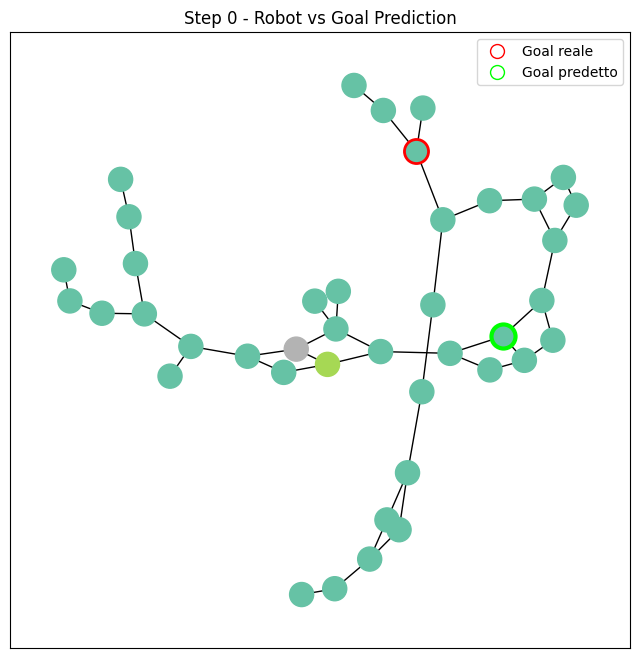

Step 1 | Probabilità sul nodo predetto (34): 0.0352 | Goal Reale: 17


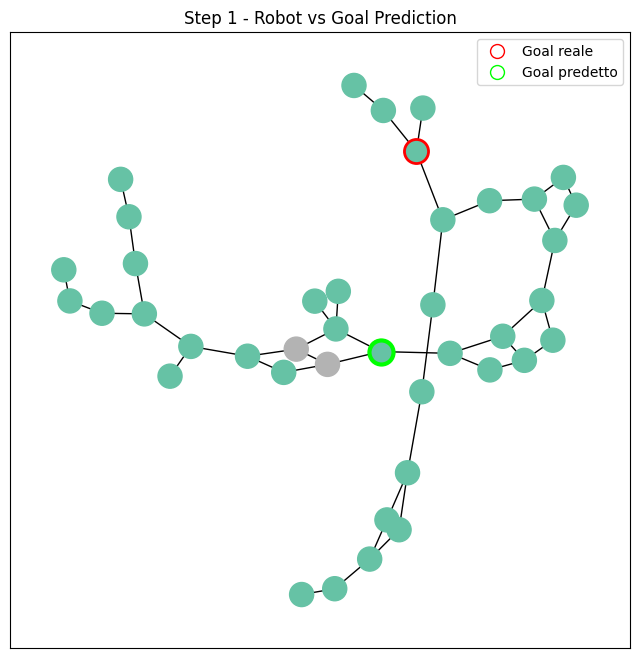

Step 2 | Probabilità sul nodo predetto (32): 0.0371 | Goal Reale: 17


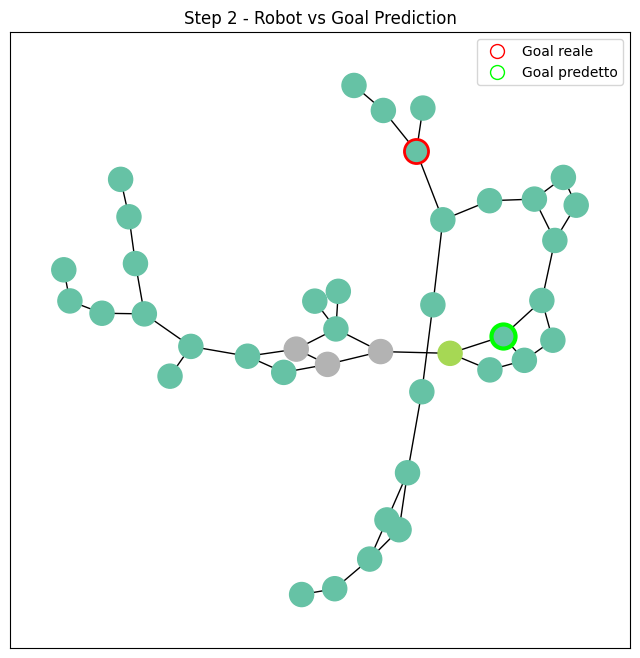

Step 3 | Probabilità sul nodo predetto (38): 0.0395 | Goal Reale: 17


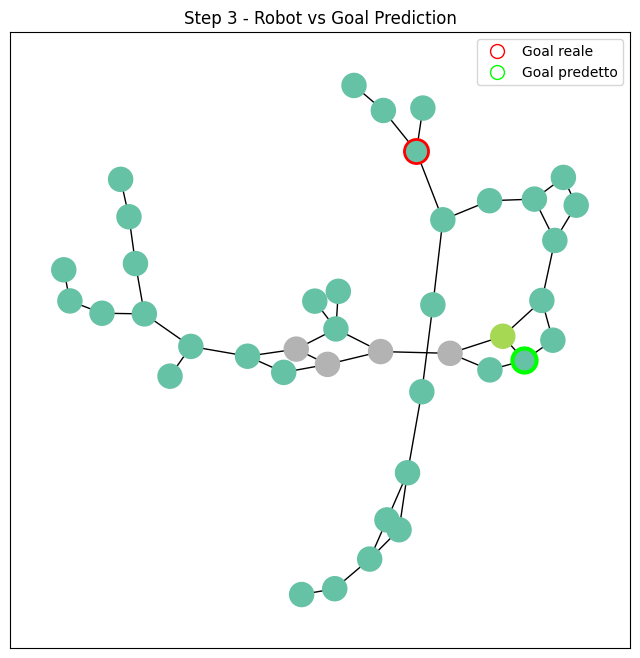

Step 4 | Probabilità sul nodo predetto (38): 0.0392 | Goal Reale: 17


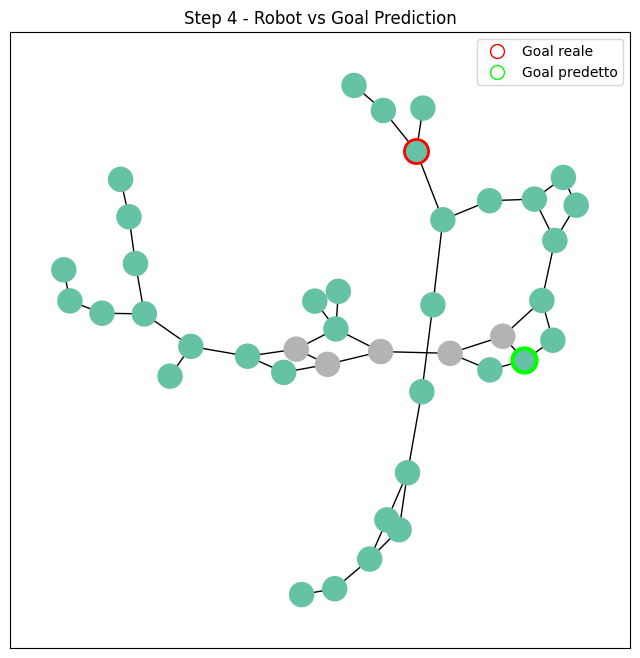

Step 5 | Probabilità sul nodo predetto (30): 0.0377 | Goal Reale: 17


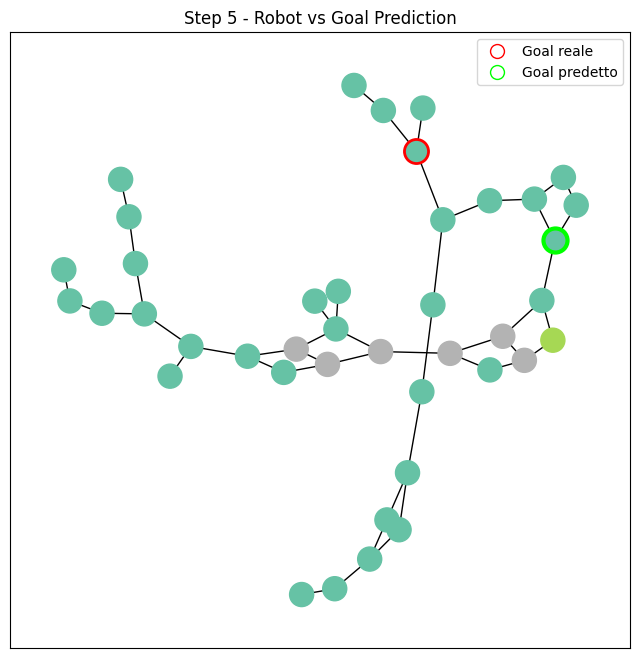

Step 6 | Probabilità sul nodo predetto (30): 0.0400 | Goal Reale: 17


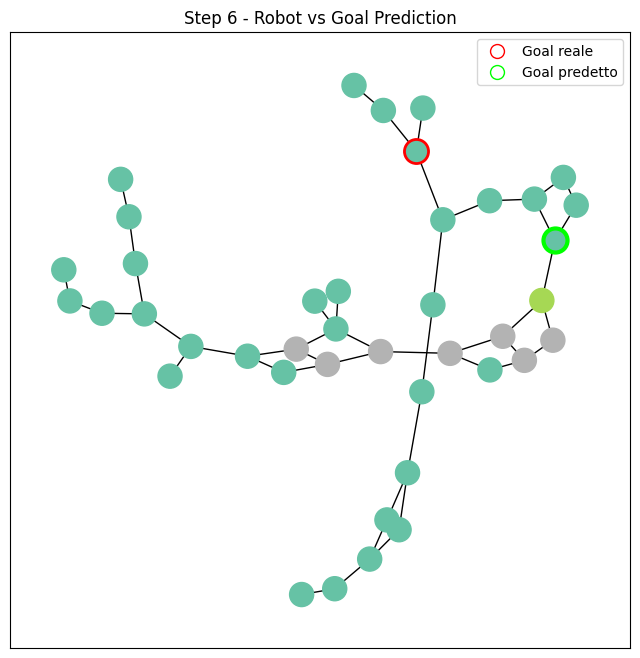

Step 7 | Probabilità sul nodo predetto (26): 0.0447 | Goal Reale: 17


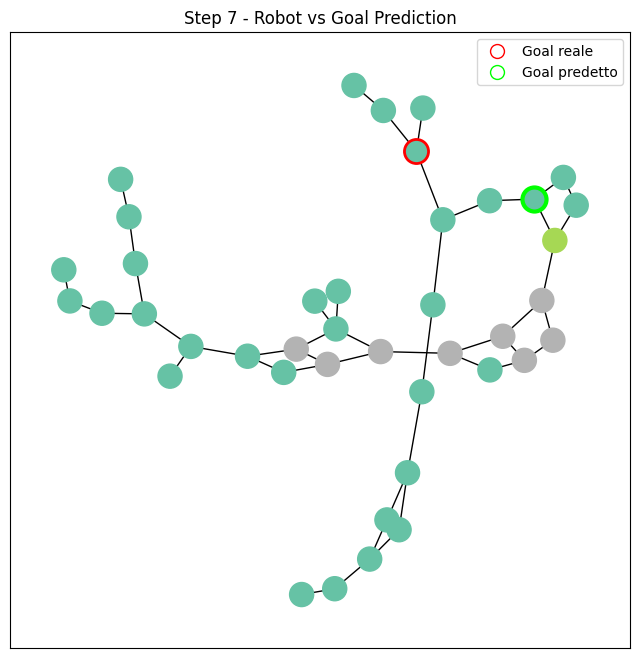

Step 8 | Probabilità sul nodo predetto (17): 0.0489 | Goal Reale: 17


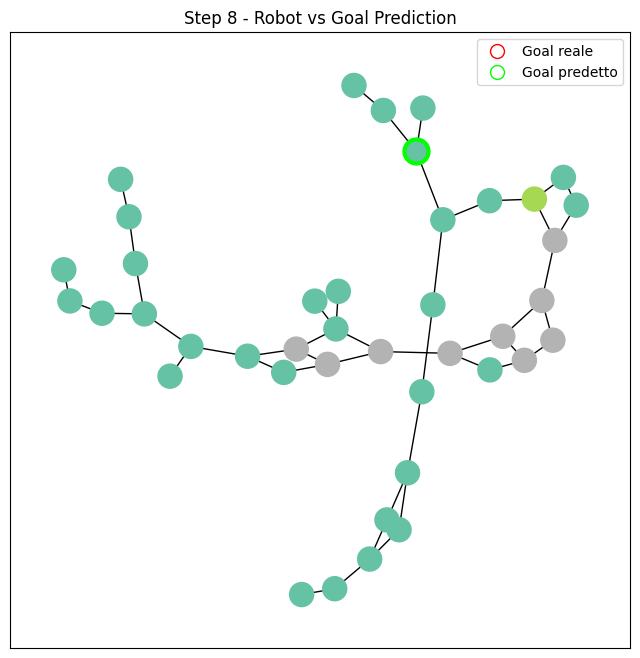

Step 9 | Probabilità sul nodo predetto (17): 0.0687 | Goal Reale: 17


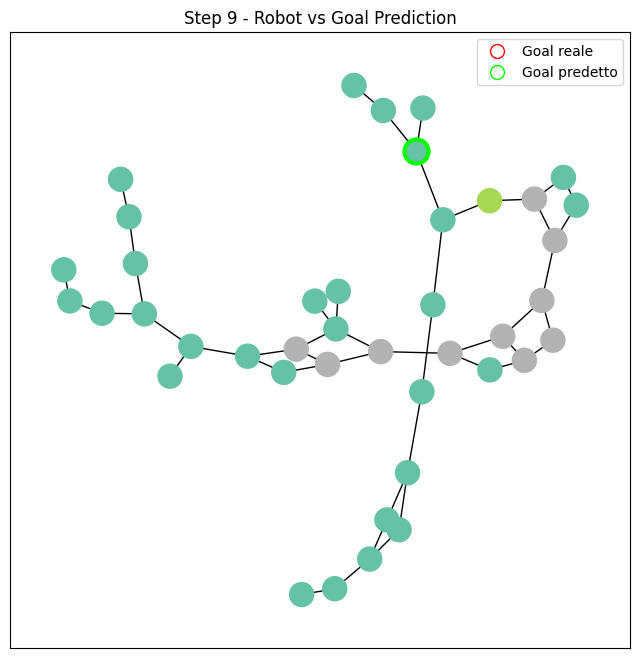

Step 10 | Probabilità sul nodo predetto (17): 0.0597 | Goal Reale: 17


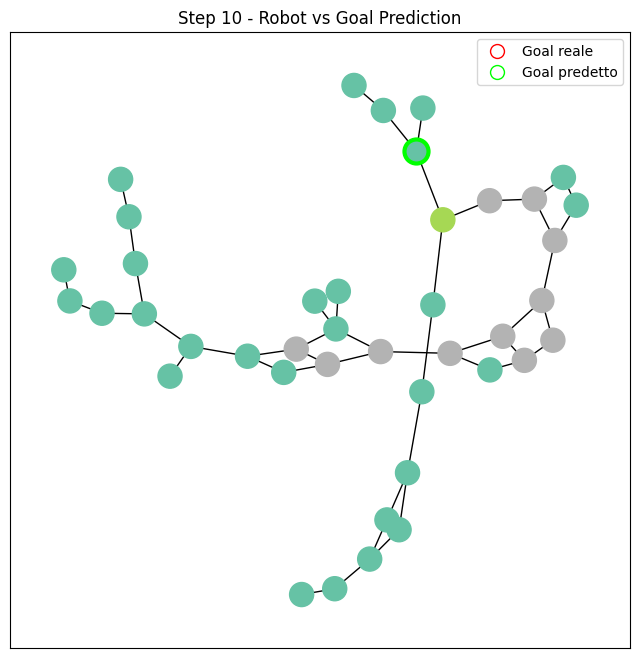

Step 11 | Probabilità sul nodo predetto (18): 0.0992 | Goal Reale: 17


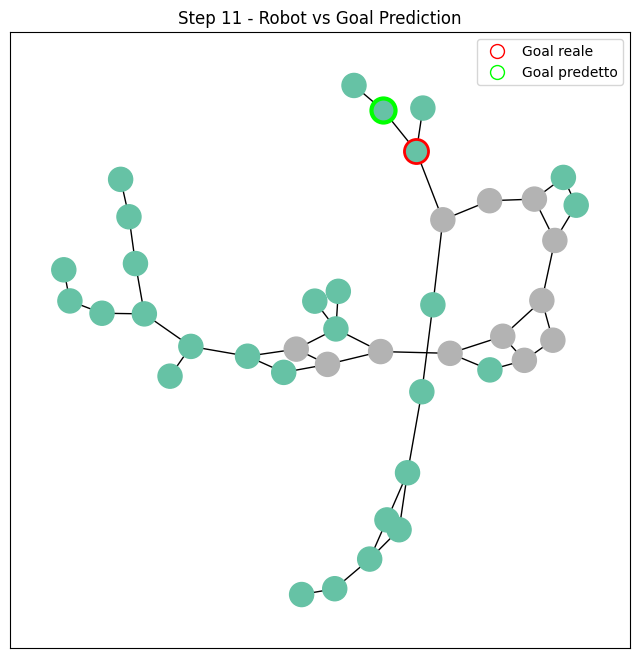

Numero predizioni 12
Goals predetti (indici):
[32, 34, 32, 38, 38, 30, 30, 26, 17, 17, 17, 18]

Lunghezza percorso reale: 13


In [39]:
from torch_geometric.utils import to_networkx
import numpy as np
import torch

# 1. Recuperiamo il numero di input channels. 
# Se hai seguito il consiglio delle coordinate relative, questo deve essere 5.
# Se non è in best_params, lo mettiamo fisso a 5.
in_channels_val = best_params.get('in_channels', 3) 

# 2. Inizializzazione corretta con i nuovi parametri dinamici
best_model = NodeClassificator(
    in_channels=in_channels_val, 
    hidden_channels=best_params['hidden_channels'], # Ora è un valore singolo
    num_layers=best_params['num_layers'],           # Nuovo parametro
    dropout=best_params['dropout']
).to(device)

# Carica i pesi
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

resulted_goals = []

print(f"--- Visualizzazione Percorso {pathIndex} su Mappa {mapIndex} ---\n")

for i, paths in enumerate(map_and_paths):
    data = paths.to(device)
    
    with torch.no_grad():
        # Batch index fittizio per un singolo grafo
        batch_index = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        # Forward pass (restituisce probabilità)
        probs = best_model(data.x, data.edge_index, batch_index)

    # Output cleaning
    probs = probs.squeeze() # Toglie dimensioni extra
    
    # --- Identificazione Goal Predetto ---
    pred_idx = probs.argmax().item()
    resulted_goals.append(pred_idx)
    
    # --- Identificazione Goal Reale (Ground Truth) ---
    # Nota: Se data.y è una heatmap, prendiamo l'indice col valore più alto come "Vero Goal"
    # per disegnarlo col bordo rosso. Usare > 0.5 potrebbe fallire se la heatmap è "sfocata".
    true_goal_idx = data.y.argmax().item()
    
    # Creazione Maschere per Visualizzazione
    # Maschera Predizione (Verde)
    predicted_mask = np.zeros(data.num_nodes, dtype=bool)
    predicted_mask[pred_idx] = True
    
    # Maschera Verità (Rosso)
    true_goal_mask = np.zeros(data.num_nodes, dtype=bool)
    true_goal_mask[true_goal_idx] = True

    # --- Preparazione Colori Nodi ---
    # Prendiamo solo i primi 3 canali (Free, Agent, Visited) per decidere il colore di base
    # Ignoriamo le coordinate (canali 3 e 4) per la colorazione
    node_states = torch.argmax(data.x[:, :3], dim=1).cpu().numpy()

    # Conversione a NetworkX
    G = to_networkx(data, to_undirected=True)

    print(f"Step {i} | Probabilità sul nodo predetto ({pred_idx}): {probs[pred_idx]:.4f} | Goal Reale: {true_goal_idx}")

    visualize_graph(
        f"Step {i} - Robot vs Goal Prediction",
        G,
        color=node_states,
        train_mask=true_goal_mask,  # Bordo ROSSO (Vero Goal)
        pred_mask=predicted_mask,   # Bordo VERDE (Predizione)
        node_size=300
    )

print(f"Numero predizioni {len(resulted_goals)}")
print(f"Goals predetti (indici):\n{resulted_goals}\n")

# Verifica lunghezza percorso originale
# Nota: maps[mapIndex] deve essere accessibile qui
if 'maps' in locals():
    print(f"Lunghezza percorso reale: {len(maps[mapIndex].O[pathIndex])}")

In [ ]:
"""
from torch_geometric.utils import to_networkx
import numpy as np
import torch

best_model = NodeClassificator(
    in_channels=best_params['in_channels'],
    hidden_channels_1=best_params['hidden_channels_1'],
    hidden_channels_2=best_params['hidden_channels_2'],
    linear_channels=best_params['linear_channels'],
    dropout=best_params['dropout']
).to(device)

MODEL_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

resulted_goals = []
resulted_paths = []

print("\n--- INIZIO PREDIZIONE PROGRESSIVA ---\n")

for i, data in enumerate(map_and_paths):
    data = data.to(device)

    # Nodo iniziale del robot (posizione corrente)
    current_node = torch.argmax(data.x[:, 1]).item()
    visited_nodes = set([current_node])
    predicted_path = [current_node]

    print(data)

    print(f"\n🗺️  Mappa {i+1}/{len(map_and_paths)} - Nodo iniziale: {current_node}")

    while True:
        # --- Aggiorna feature dei nodi ---
        x_updated = data.x.clone()
        x_updated[:, 1] = 0               # reset posizione robot
        x_updated[current_node, 1] = 1    # nodo corrente = posizione robot
        for v in visited_nodes:
            x_updated[v, 0] = 1           # nodi visitati

        # --- Predizione del goal ---
        with torch.no_grad():
            out = best_model(x_updated, data.edge_index)
            probs = torch.sigmoid(out).squeeze().cpu()

        # Maschera nodi già visitati
        probs_masked = probs.clone()
        for v in visited_nodes:
            probs_masked[v] = -float('inf')

        # Se tutti i nodi sono stati visitati → fine
        if torch.all(probs_masked == -float('inf')):
            print("⚠️  Tutti i nodi visitati, fermo qui.")
            break

        # Nodo predetto come prossimo o goal
        pred_idx = probs_masked.argmax().item()
        pred_prob = probs[pred_idx].item()

        # Aggiorna stato
        visited_nodes.add(pred_idx)
        predicted_path.append(pred_idx)
        current_node = pred_idx

        # Se la probabilità è abbastanza alta → goal trovato
        if pred_prob > 0.5:
            print(f"🏁 Goal trovato nel nodo {pred_idx} con prob {pred_prob:.4f}")
            resulted_goals.append(pred_idx)
            break

    resulted_paths.append(predicted_path)

    # Visualizza grafo del risultato finale
    G = to_networkx(data, to_undirected=True)
    node_states = torch.argmax(x_updated, dim=1).cpu().numpy()
    predicted_mask = np.zeros(len(node_states), dtype=bool)
    predicted_mask[predicted_path[-1]] = True
    is_goal = data.y.cpu().numpy() > 0.5

    visualize_graph(
        f"Graph - Predizione finale mappa {i+1}",
        G,
        color=node_states,
        train_mask=is_goal,
        pred_mask=predicted_mask,
        node_size=300
    )

print("\n--- RISULTATI FINALI ---")
for i, (goal, path) in enumerate(zip(resulted_goals, resulted_paths)):
    print(f"Mappa {i+1}: Goal predetto = {goal}, Lunghezza percorso = {len(path)}")
    """
